# Libraries

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

In [3]:
from models.load_models_1d import *
from dataloaders.load_1d_meteo_wtd import ContinuousDataset
from subprocess import Popen

# Load dictionary

In [4]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/continuous_1D_wtd/test_1D.json"
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'experiment_name': 'first_pinns_test_1D_norm', 'run_name': 'Random_trial_fullDS_skip_long_HB', 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/models', 'data_dir': '/leonardo_work/IscrC_DL4EO/trials/data/', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'timesteps': 180, 'test_split_p': 0.2, 'all_dataset': True, 'max_ds_elems': 100000, 'normalization': False, 'fill_value': 0, 'transform': None, 'piezo

# Dataset class

In [27]:
dict_files["piezo_head"] = True

In [28]:
ds = ContinuousDataset(dict_files)

In [34]:
ds.weather_xr.sel(time = slice(np.datetime64("2020-01-01"))) #slice include extremes

<xarray.Dataset> Size: 136MB
Dimensions:      (time: 22404, lat: 9, lon: 12)
Coordinates:
  * lon          (lon) float64 96B 6.688 6.813 6.938 7.063 ... 7.813 7.938 8.063
  * lat          (lat) float64 72B 45.31 45.19 45.06 44.94 ... 44.56 44.44 44.31
  * time         (time) datetime64[ns] 179kB 1958-08-31 ... 2020-01-01
    spatial_ref  int64 8B 0
Data variables:
    prec         (time, lat, lon) float32 10MB ...
    tmax         (time, lat, lon) float32 10MB ...
    tmin         (time, lat, lon) float32 10MB ...
    tmean        (time, lat, lon) float32 10MB ...
    prain        (time, lat, lon) float32 10MB ...
    psnow        (time, lat, lon) float32 10MB ...
    et_0         (time, lat, lon) float64 19MB ...
    r_a          (time, lat, lon) float64 19MB ...
    snowpack     (time, lat, lon) float64 19MB ...
    snowmelt     (time, lat, lon) float64 19MB ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue May 14 07:41:14 2024: cdo -r settaxis,1957-12-01,12:00,...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

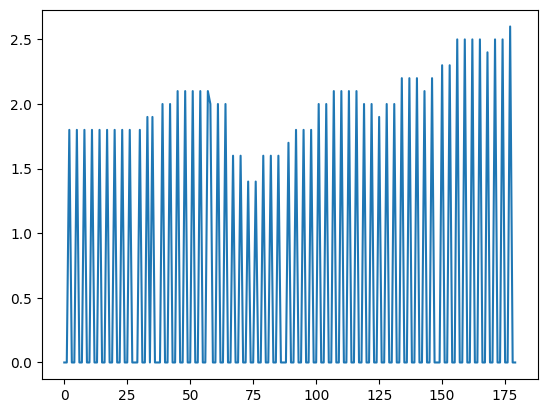

In [25]:
plt.plot(np.nan_to_num(ds[0][3].numpy()))

(290.0, 300.0)

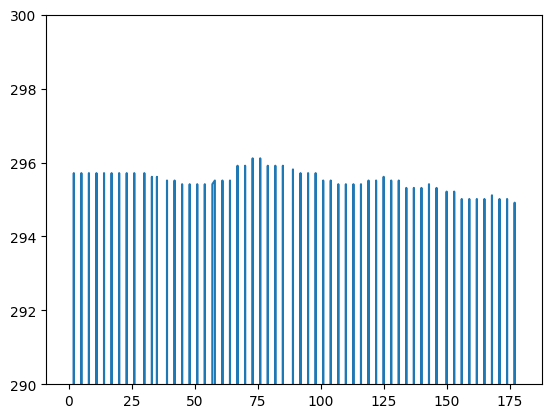

In [30]:
plt.plot(np.nan_to_num(ds[0][3].numpy()))
plt.ylim(290,300)

In [49]:

heights = []
ds.wtd_df["h"] = np.nan

for station_idx in range(len(ds.sensor_id_list)):
    
    altitude_idx = ds.dtm_roi.sel(x = ds.wtd_names.geometry.x[station_idx],
               y = ds.wtd_names.geometry.y[station_idx],
               method = "nearest").values
    
    ds.wtd_df.loc[ds.wtd_df["sensor_id"] == ds.sensor_id_list[station_idx], "h"] = altitude_idx - ds.wtd_df.loc[ds.wtd_df["sensor_id"] == ds.sensor_id_list[station_idx], "wtd"] 
    
    heights.append(altitude_idx)
    
    
ds.wtd_names["height"] = np.array(heights)

In [51]:
ds.wtd_df

sensor_id        wtd  nan_mask           h
date       y         x                                                     
2001-01-01 44.698854 7.640289  00405910001   1.800000      True  295.713123
           44.567817 7.726400  00408910001   3.981667      True  293.833763
           44.418627 7.537215  00407810001  39.876667      True  196.046948
           44.860859 7.723791  00105910001        NaN     False         NaN
           44.963005 7.673142  00112710001        NaN     False         NaN
...                                    ...        ...       ...         ...
2023-12-31 44.956561 7.598704  00105110001   3.553333      True  281.379650
           44.787024 7.735140  00404110001        NaN     False         NaN
           45.005577 7.894828  00121510001  14.500000      True  273.790009
           44.965446 7.770635  00104810001   2.056667      True  370.360234
           45.024540 7.663686  00127210005        NaN     False         NaN

[260400 rows x 4 columns]

In [36]:
ds.dtm_roi.sel(x = ds.wtd_names.geometry.x[0],
               y = ds.wtd_names.geometry.y[0],
               method = "nearest").values

array([297.51312], dtype=float32)

In [6]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 254820


# Model 

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [8]:
model = Continuous1DNN(timestep = dict_files["timesteps"],
                 cb_fc_layer = dict_files["cb_fc_layer"], #5,
                 cb_fc_neurons = dict_files["cb_fc_neurons"], # 32,
                 conv_filters = dict_files["conv_filters"], #32,
                 lstm_layer = dict_files["lstm_layer"], #5,
                 lstm_input_units = dict_files["lstm_input_units"], #16,
                 lstm_units = dict_files["lstm_units"] #32
                 ).to(device)

In [9]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  846209


# Training

In [8]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SequentialSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=test_sampler)

Traing size: 203856, Test size: 50964


In [9]:
def plot_predictions(x, y, y_hat, save_dir = None, title = None):
    fig, ax = plt.subplots()
    fig.suptitle("Loss vs iterations")
    ax.plot(x, y_hat, label = "predicted")
    ax.plot(x, y, label = "true")
    ax.legend()
    
    if title is not None:
        ax.set_title(title)
        
    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    
    return fig

In [10]:
def masked_mse(y_hat, y, mask):
    # y_hat = y_hat.to(device)
    # y = y.to(device)
    # mask = mask.to(device)
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [13]:
wandb.init(
    entity="gsartor-unito",
    project=dict_files["experiment_name"],
    dir =dict_files["wandb_dir"],
    config=dict_files,
    mode="offline",
)

# Magic
wandb.watch(model, log_freq=100)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


mem allocated in MB:  0.0
############### Training epoch 0 ###############


  0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 0:   0%|          | 0/250 [00:02<?, ?batch/s]

Train loss: 425.80499267578125


Epoch 0:   0%|          | 1/250 [00:11<35:03,  8.45s/batch]

Train loss: 480.5107116699219


Epoch 0:   0%|          | 1/250 [00:16<1:09:58, 16.86s/batch]


############### Test epoch 0 ###############


Epoch 0:   2%|▏         | 1/63 [00:04<04:44,  4.59s/batch]

Test loss: 425.613525390625


Epoch 0:   2%|▏         | 1/63 [00:09<09:36,  9.29s/batch]


Test loss: 480.4068298339844
############### Training epoch 1 ###############


  0%|          | 0/250 [00:01<?, ?batch/s]


KeyboardInterrupt: 

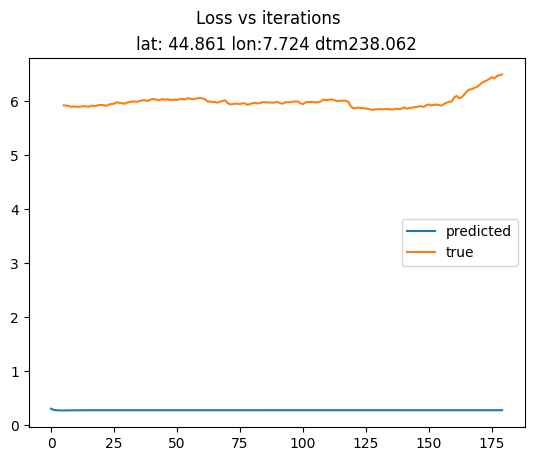

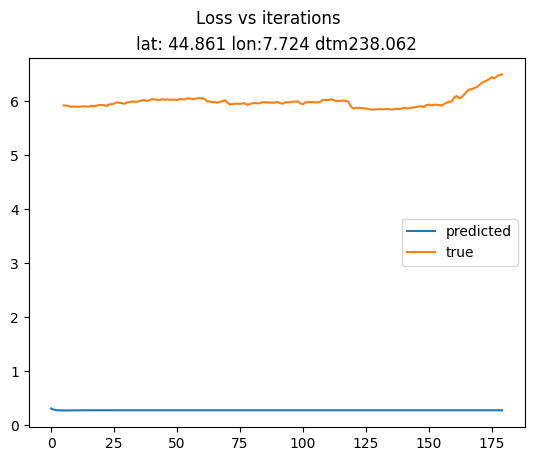

In [17]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)

print('mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

for i in range(max_epochs):
    
    model.train(True)
    start_time = time.time()
    print(f"############### Training epoch {i} ###############")
    
    with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {i}")
                
                x = x.to(device)
                x_mask = x_mask.to(device)
                z = z.to(device)
                weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                w = [w_values.to(device), weather_coords_batch.to(device)]
                y = y.to(device)
                y_mask = y_mask.to(device)
                #print('Batch mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)
                
                optimizer.zero_grad()
                
                y_hat = model(x, z, w, x_mask)
                #print('After predict mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)
                loss = masked_mse(y_hat,
                                  y,
                                  y_mask)
                
                print(f"Train loss: {loss}")
                
                loss.backward()
                optimizer.step()
                
                metrics = {
                    "train_loss" : loss
                }
                wandb.log(metrics) 
                
                if batch_idx == 1:
                    break             
                
    end_time = time.time()
    exec_time = end_time-start_time

    wandb.log({"tr_epoch_exec_t" : exec_time})
    # Log the plot
    lat_plot = round(float(z[-1,0].detach().cpu()), 4)
    lon_plot = round(float(z[-1,1].detach().cpu()), 4)
    dtm_plot = round(float(z[-1,2].detach().cpu()))
    wandb.log({"training_pred":wandb.Image(plot_predictions(np.arange(0,dict_files["timesteps"]),
                                                 y[-1,:].detach().cpu(), y_hat[-1,:].detach().cpu(),
                                        title = f"lat: {lat_plot} lon:{lon_plot} dtm:{dtm_plot}"))
               })

    model_name = 'model_{}_{}.pt'.format(timestamp, i)    
    model_dir = dict_files["save_model_dir"]
    torch.save(model.state_dict(), f"{model_dir}/{model_name}") 

    print(f"############### Test epoch {i} ###############")
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    start_time = time.time()
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
                for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                    tepoch.set_description(f"Epoch {i}")

                    x = x.to(device)
                    x_mask = x_mask.to(device)
                    z = z.to(device)
                    weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                    w = [w_values.to(device), weather_coords_batch.to(device)]
                    y = y.to(device)
                    y_mask = y_mask.to(device)
                    # print('Batch mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)

                    y_hat = model(x, z, w, x_mask)
                    # print('After predict mem allocated in MB: ', torch.cuda.memory_allocated() / 1024**2)

                    loss = masked_mse(y_hat,
                                  y,
                                  y_mask)
                    print(f"Test loss: {loss}")

                    metrics = {
                        "test_loss" : loss
                    }

                    wandb.log(metrics)
                    
                    if batch_idx == 1:
                        break  
        
    end_time = time.time()
    exec_time = end_time-start_time
    wandb.log({"test_epoch_exec_t" : exec_time})
    # Log the plot
    lat_plot = round(float(z[-1,0].detach().cpu()), 4)
    lon_plot = round(float(z[-1,1].detach().cpu()), 4)
    dtm_plot = round(float(z[-1,2].detach().cpu()))
    wandb.log({"test_pred": wandb.Image(plot_predictions(np.arange(0,dict_files["timesteps"]), y[-1,:].detach().cpu(), y_hat[-1,:].detach().cpu(),
                                        title = f"lat: {lat_plot} lon:{lon_plot} dtm:{dtm_plot}"))
               })


wandb.finish()

print(f"Execution time: {end_time-start_time}s")

# Physics loss

In [ ]:
# grad function

In [ ]:
def physics_loss(model: torch.nn.Module):
    control_points_x_ode = torch.linspace(-100, 100, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    control_points_y_ode = model(control_points_x_ode)
    ode_est = grad(control_points_y_ode, control_points_x_ode)[0]
    pde = 2*control_points_x_ode - ode_est
    
    # Metti temporal encoding in input? 
    pde = 
    pde_res = 
    
    return torch.mean(pde**2)

# Test plots

In [10]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)
#offset_idx = 100000

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx,
                                                        train_idx + test_idx)

train_sampler = SequentialSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=31,
                                            sampler=test_sampler)

Traing size: 203856, Test size: 50964


In [17]:
model_path = "/leonardo_scratch/fast/IscrC_DL4EO/results/continuous_1d/models/model_20241231_124957.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

Continuous1DNN(
  (wgamma): Sigmoid()
  (cb_fc): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=256, bias=True)
  )
  (weather_wgamma): Sigmoid()
  (conv3d_stack): Sequential(
    (0): Conv3d(10, 32, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(32, 32, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv3d(32, 32, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (7): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv3d(32, 32, kernel_size=(1, 2, 2), stride=(1, 1, 1))
    (10): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv3d(32, 32, kernel_size=(1, 2, 2), stride=(1

In [13]:
def masked_mse(y_hat, y, mask):
    return torch.sum(((y_hat[mask]-y[mask]))**2.0)  / torch.sum(mask)

def masked_mae(y_hat, y, mask):
    return torch.sum(torch.abs((y_hat[mask]-y[mask])))  / torch.sum(mask)

In [18]:
weather_coords = ds.get_weather_coords()
weather_dtm = ds.get_weather_dtm()
weather_coords = torch.cat([weather_coords, weather_dtm], dim = -1)

y_list = []
y_hat_list = []
mse_list = []
mae_list = []

with tqdm(test_loader, unit="batch") as tepoch:
                for batch_idx, (x, z, w_values, y, x_mask, y_mask) in enumerate(tepoch):
                    #tepoch.set_description(f"Epoch {i}")

                    x = x.to(device)
                    x_mask = x_mask.to(device)
                    z = z.to(device)
                    weather_coords_batch = weather_coords.unsqueeze(0).expand(w_values.shape[0], -1, -1, -1)
                    w = [w_values.to(device), weather_coords_batch.to(device)]
                    y = y.to(device)
                    y_mask = y_mask.to(device)
                    
                    y_hat = model(x, z, w, x_mask)
                    # denormalize 
                    y_hat = (y_hat * ds.wtd_std) + ds.wtd_mean
                    y = (y * ds.wtd_std) + ds.wtd_mean
                    
                    y_list.append(y)
                    y_hat_list.append(y_hat)

                    mse = masked_mse(y_hat,
                                  y,
                                  y_mask)
                    mse_list.append(mse)
                    
                    mae = masked_mae(y_hat,
                                  y,
                                  y_mask)
                    mae_list.append(mae)
                    
                    if batch_idx == 5:
                        break

  0%|          | 0/1644 [00:00<?, ?batch/s]

  0%|          | 5/1644 [00:14<1:18:49,  2.89s/batch]


In [19]:
sample_day = 0

In [35]:
#ds.wtd_names["munic"].loc[ds.wtd_names["sensor_id"] == ds.wtd_df["sensor_id"].loc[:, ds[0][1][0], ds[0][1][1]]]

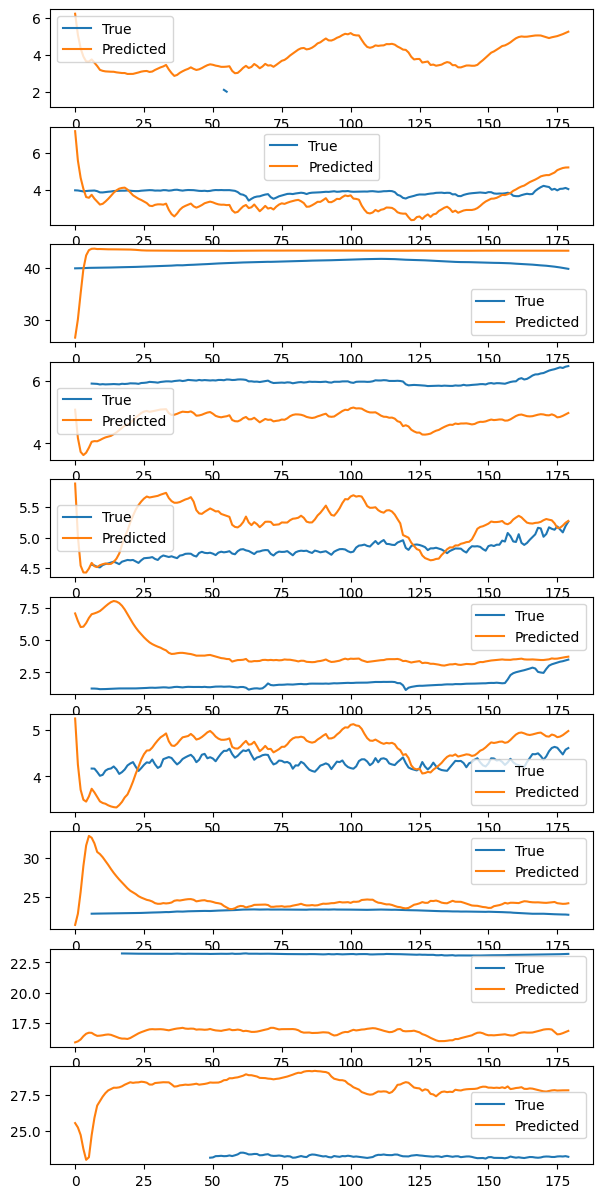

In [20]:
fig, ax = plt.subplots(10, figsize = (7,15))
for i in range(10):
        ax[i].plot(np.arange(180), y_list[3][(sample_day * 31) + i, :].detach().numpy(), label = "True")
        ax[i].plot(np.arange(180), y_hat_list[3][(sample_day * 31) + i, :].detach().numpy(), label = "Predicted")
        ax[i].legend()

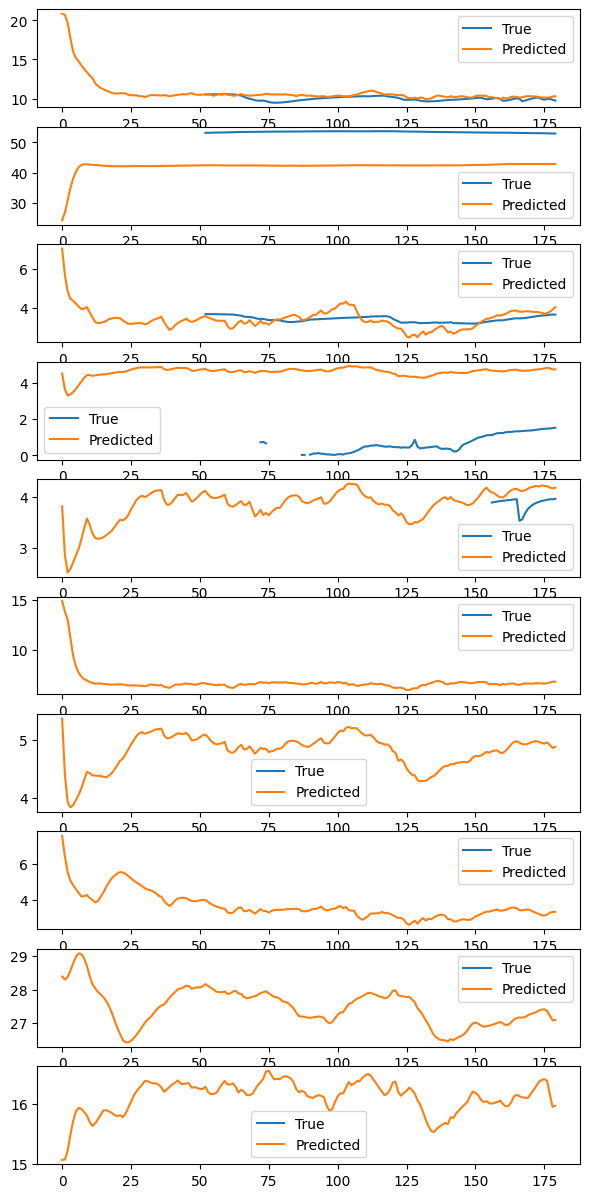

In [21]:
fig, ax = plt.subplots(10, figsize = (7,15))
for i in range(10,20):
        ax[i-10].plot(np.arange(180), y_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "True")
        ax[i-10].plot(np.arange(180), y_hat_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "Predicted")
        ax[i-10].legend()

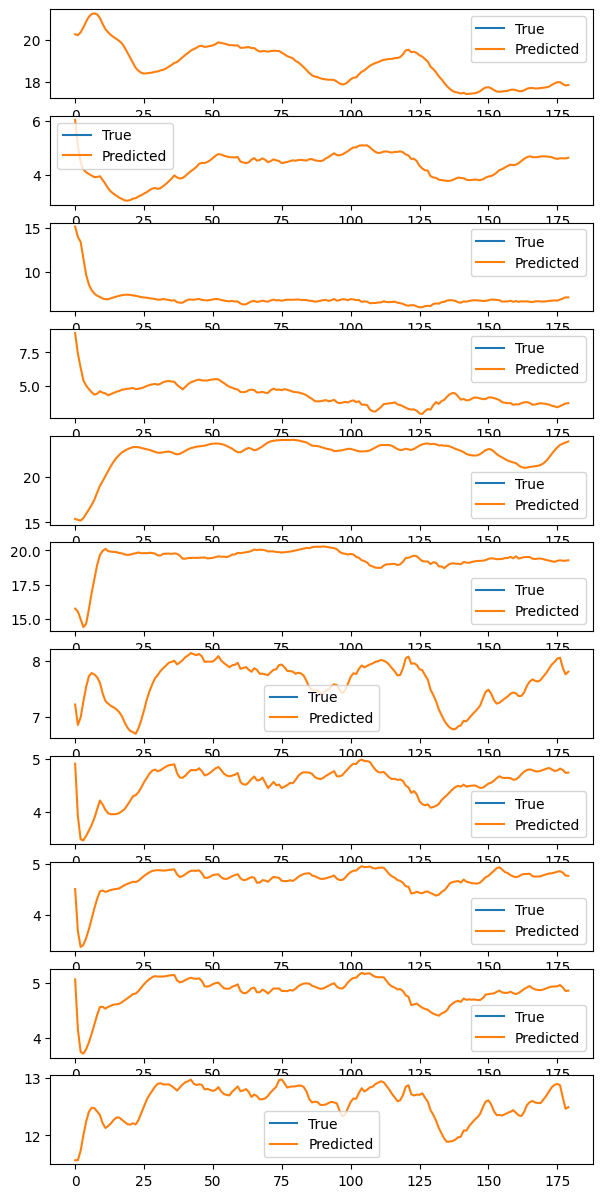

In [22]:
fig, ax = plt.subplots(11, figsize = (7,15))
for i in range(20,31):
        ax[i-20].plot(np.arange(180), y_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "True")
        ax[i-20].plot(np.arange(180), y_hat_list[0][(sample_day * 31) + i, :].detach().numpy(), label = "Predicted")
        ax[i-20].legend()

In [ ]:
MAE = nn.L1Loss()
MSE = nn.MSELoss()

# Compute MAE
output_tensor = MAE(test_prediction, test_target)

# Compute RMSE
RMSE = MSE(test_prediction, test_target)
RMSE = torch.sqrt(RMSE)

print("MAE: ", MAE)
print("RSME: ", RMSE)